# Example of usage Spark OCR for Table Recognition

This notebook demonstrate pipeline for extract tabular data from image of the table with usage of RegionsMerger to improve detected regions.

For more details about table recognition please read: [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

## Install spark-ocr python packge
Need to specify:
- secret
- license
- aws credentials

In [1]:
secret = ""
license = ""

spark_ocr_jar_path = "../../target/scala-2.11"

In [3]:
# install from local package 
#%pip install ../../python/dist/spark-ocr-3.7.0+spark30.tar.gz

In [4]:
# install from PYPI using secret
#%pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [2]:
import os

os.environ['SPARK_OCR_LICENSE'] = license

## Initialization of spark session
Need specify path to `spark-ocr-assembly.jar` or `secret`

In [ ]:
from pyspark import SparkConf
from sparkocr import start

spark = start(secret=secret, jar_path = spark_ocr_jar_path)

spark

## Read images and display it


    Image #0:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images/table.png
    Resolution: 143 dpi
    Width: 2298 px
    Height: 1650 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


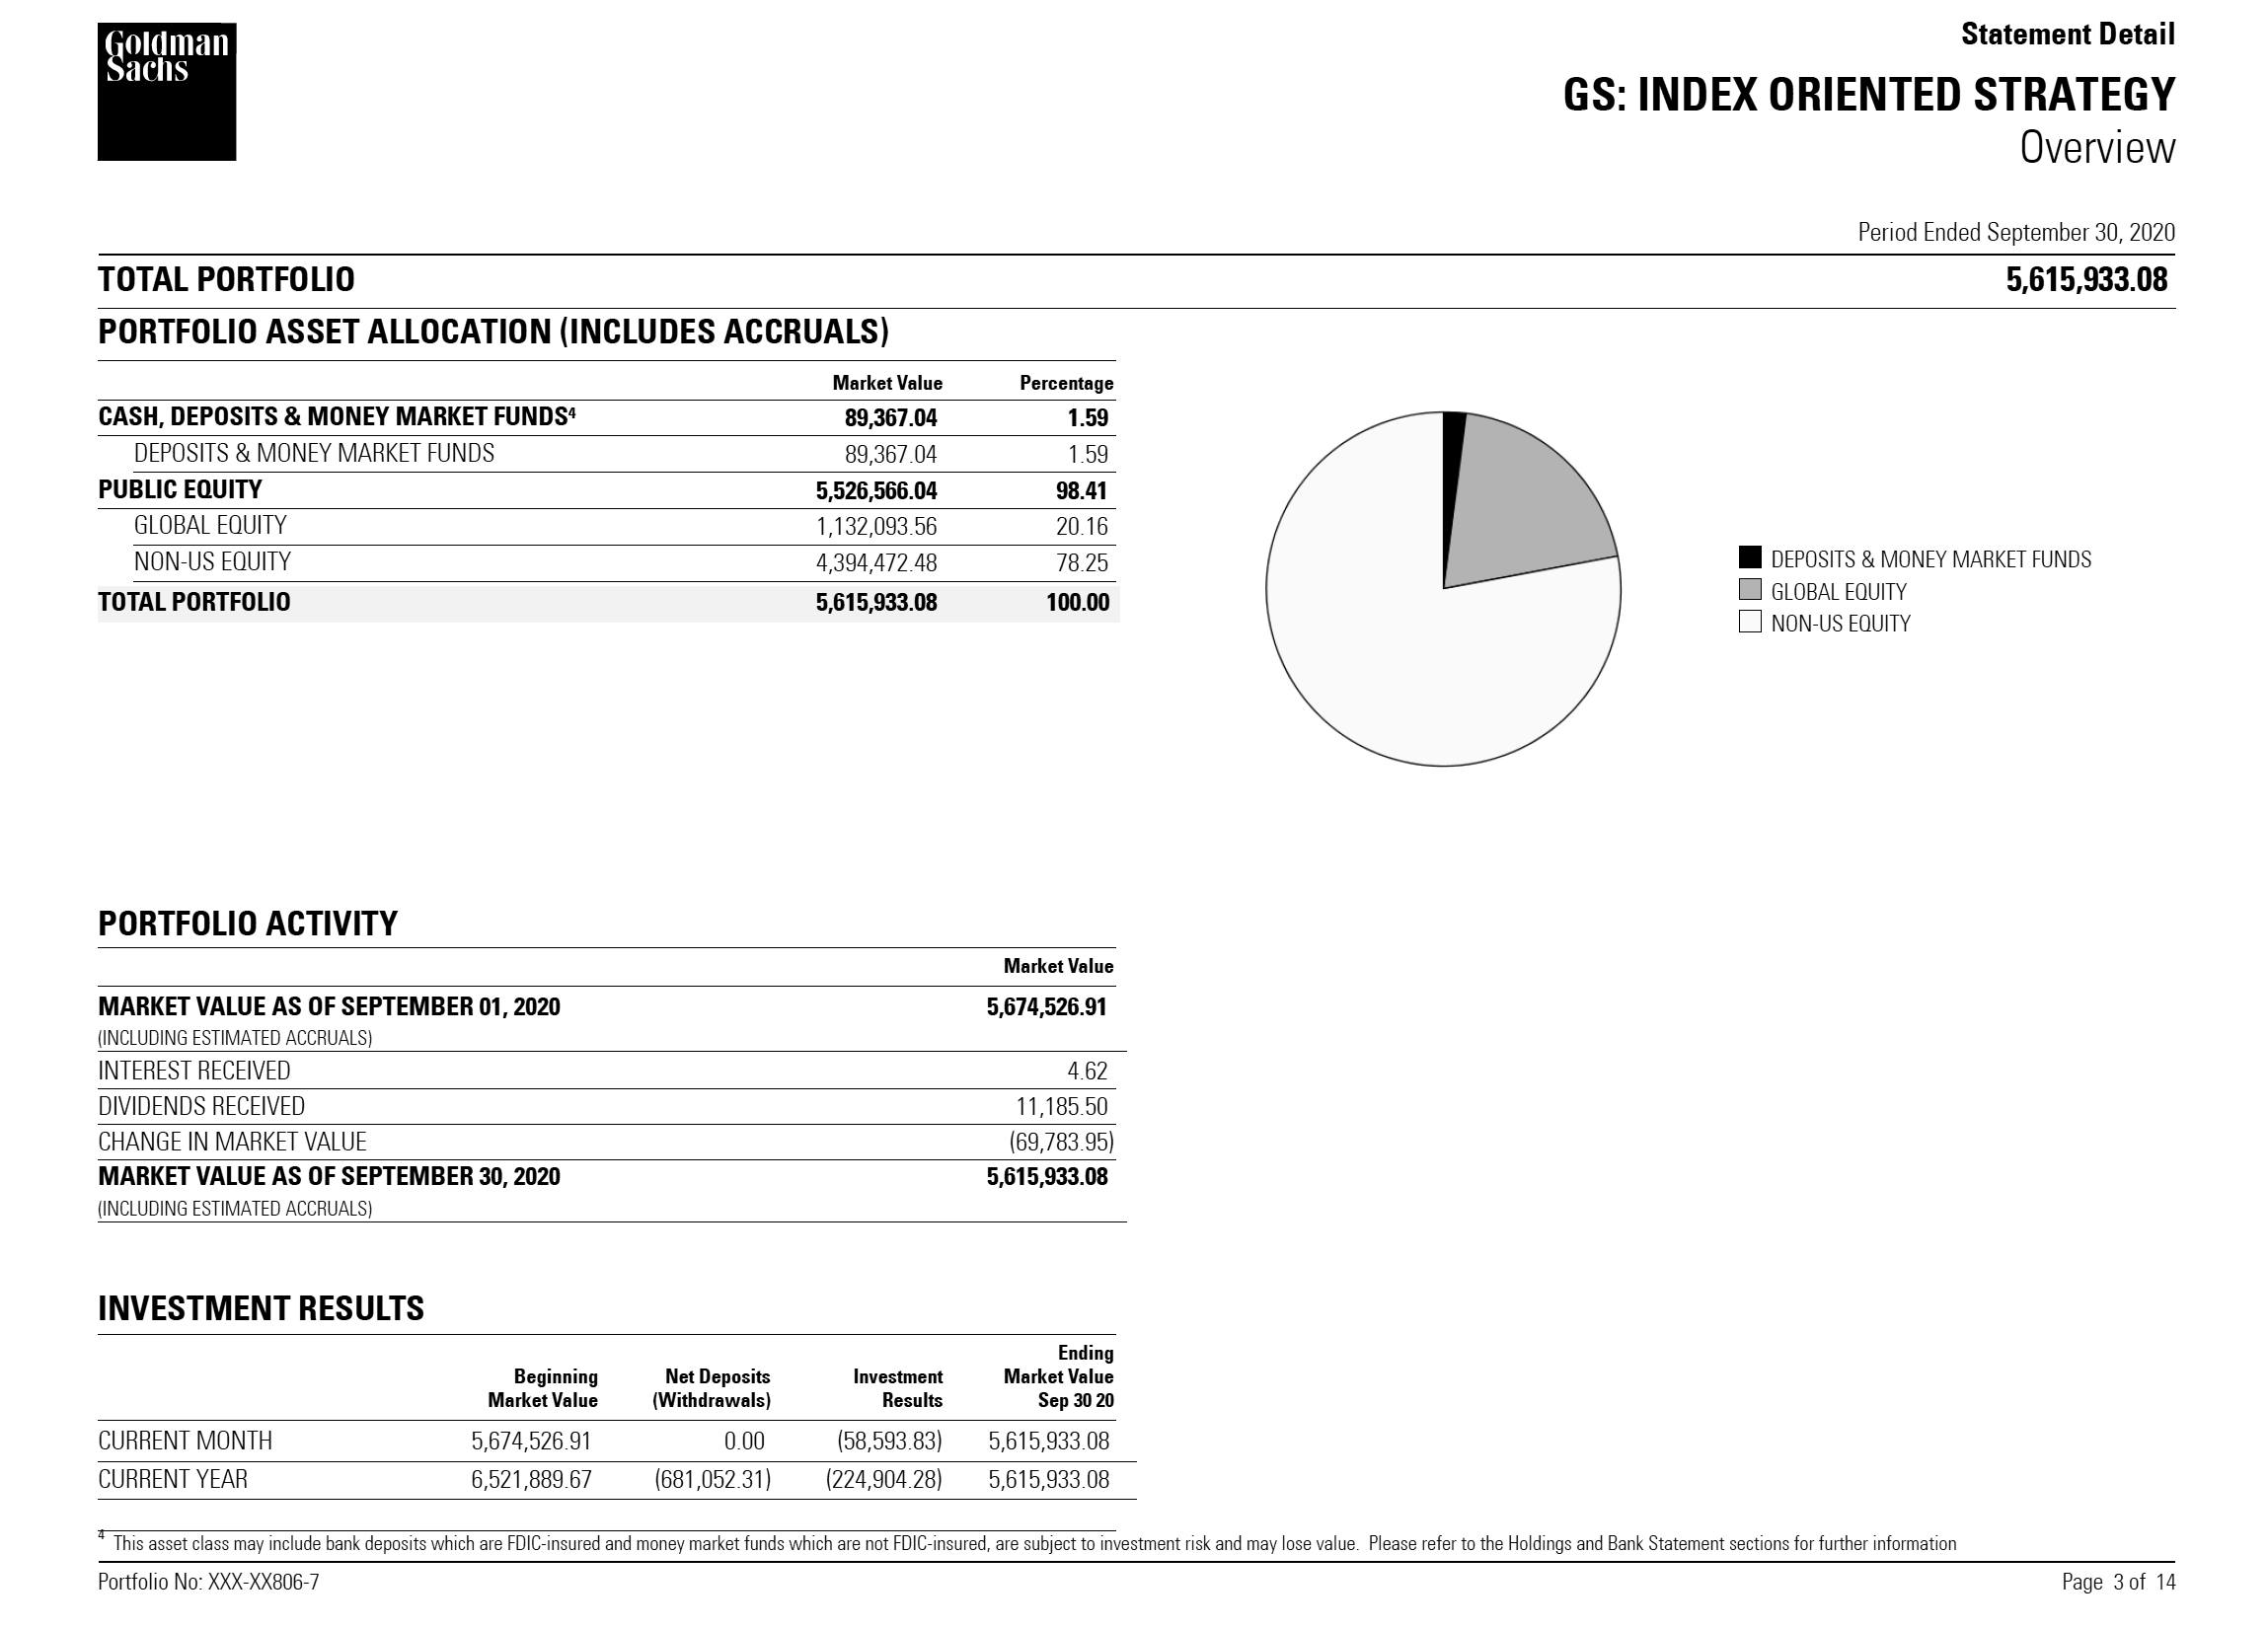

In [9]:
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images, display_table, display_tables
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

import pkg_resources
test_image_path = "./data/tab_images/table.png"
image_df= spark.read.format("binaryFile").load(test_image_path)

display_images(BinaryToImage().transform(image_df), "image")

## Define OCR Pipeline

In [10]:
binary_to_image = BinaryToImage() \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

table_detector = ImageTableDetector \
    .pretrained("table_detection_v3", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("table_regions") \
    .setScoreThreshold(0.5) \
    .setApplyCorrection(True)

splitter = ImageSplitRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("table_regions") \
    .setOutputCol("table_image") \
    .setDropCols("image")

text_detector = ImageTextDetector() \
    .pretrained("image_text_detector_opt", "en", "clinical/ocr") \
    .setInputCol("table_image") \
    .setOutputCol("text_regions") \
    .setWithRefiner(False) \
    .setWidth(0)

cell_detector = ImageDocumentRegionDetector \
    .pretrained("region_cell_detection_v2", "en", "clinical/ocr") \
    .setInputCol("table_image") \
    .setOutputCol("cells") \
    .setScoreThreshold(0.8)

merger = RegionsMerger() \
    .setInputCols(["text_regions"]) \
    .setCellInputCol("cells") \
    .setImageInputCol("table_image") \
    .setOutputCol("merged_regions") \
    .setKeepTextRegions(True)

draw_regions = ImageDrawRegions() \
    .setInputCol("table_image") \
    .setInputRegionsCol("merged_regions") \
    .setOutputCol("image_with_merged_regions") \
    .setRectColor(Color.green)

img_to_hocr = ImageToTextV2 \
    .pretrained("ocr_base_printed_v2", "en", "clinical/ocr") \
    .setInputCols(["table_image"]) \
    .setOutputFormat(OcrOutputFormat.HOCR) \
    .setOutputCol("hocr") \
    .setGroupImages(False) \
    .setRegionsColumn("merged_regions") \
    .setIncludeConfidence(True)

hocr_to_table = HocrToTextTable() \
    .setInputCol("hocr") \
    .setOutputCol("table") \
    .setUseCellsCol("cells")
    
pipeline = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    splitter,
    text_detector,
    cell_detector,
    merger,
    draw_regions,
    img_to_hocr,
    hocr_to_table
])

table_detection_v3 download started this may take some time.
Approximate size to download 23.1 MB
image_text_detector_opt download started this may take some time.
Approximate size to download 75.8 MB
region_cell_detection_v2 download started this may take some time.
Approximate size to download 23.1 MB


## Run pipeline

In [11]:
results = pipeline.transform(image_df).cache()

## Display images with detected cells


    Image #0:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images/table.png
    Resolution: 0 dpi
    Width: 1045 px
    Height: 256 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


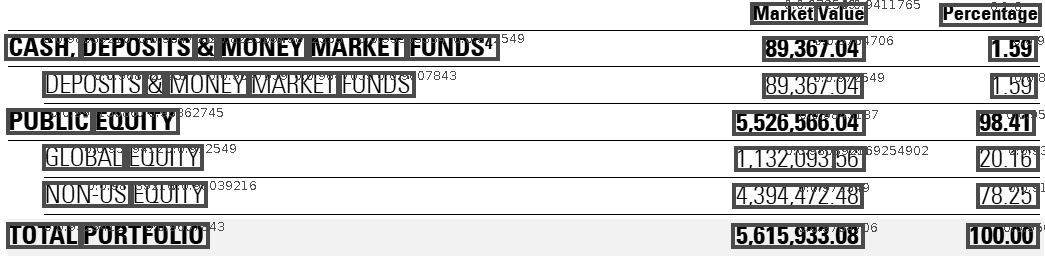


    Image #1:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images/table.png
    Resolution: 0 dpi
    Width: 1053 px
    Height: 270 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


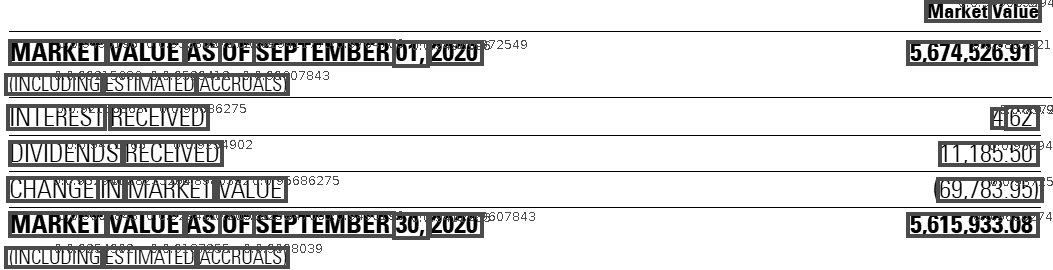


    Image #2:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images/table.png
    Resolution: 0 dpi
    Width: 1062 px
    Height: 158 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


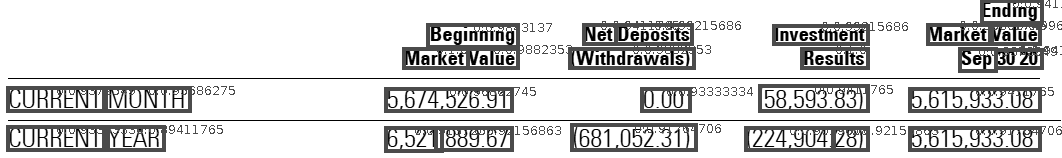

In [12]:
display_images(results, "image_with_merged_regions")

## Display recognized tables

In [15]:
results = results.withColumn("id", f.monotonically_increasing_id())

In [16]:
display_tables(results, table_index_col = "id", empty_val = "")

Filename: table.png
Page: 0
Table: 0
Number of Columns: 3


col0,col1,col2
,MARKET VALUE,PERCENTAGE
"CASH, DEPOSITS & MONEY MARKET FUNDS4","89,367.04",1.59
DEPOSITS & MONEY MARKET FUNDS,"89,367.04",1.59
PUBLIC EQUITY,"5,526,566.04",98.41
GLOBAL EQUITY,"1,132,093 56",20.16
NON-US EQUITY,"4,394,472.48",78.25
TOTAL PORTFOLIO,"5,615,933.08",100.00


Filename: table.png
Page: 0
Table: 1
Number of Columns: 2


col0,col1
,MARKET VALUE
"MARKET VALUE AS OF SEPTEMBER 01, 2020","5,674,526.91"
(INCLUDING ESTIMATED ACCRUALS),
INTEREST RECEIVED,4 62
DIVIDENDS RECEIVED,"11,185.50"
CHANGE IN MARKET VALUE,"69,783.95)"
"MARKET VALUE AS OF SEPTEMBER 30, 2020","5,615,933.08"
(INCLUDING ESTIMATED ACCRUALS),


Filename: table.png
Page: 0
Table: 2
Number of Columns: 5


col0,col1,col2,col3,col4
,BEGINNING MARKET VALUE,NET DEPOSITS (WITHDRAWALS),INVESTMENT RESULTS,ENDING MARKET VALUE SEP 30.20
CURRENT MONTH,"5,674,526.91",0.00,"(58,593.83)","5,615,933.08"
CURRENT YEAR,"6,521, ,889.67","(681,052.31)","(224,904 28)","5,615,933.08"
